# **Neural Machine Translation**

This tutorial demonstrates how to train a sequence-to-sequence (seq2seq) model for Spanish-to-English translation (using the last hidden state of the encoder).

### Installing and Importing Libraries

In [1]:
%%capture
!pip install "tensorflow-text>=2.11"

In [2]:
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import tensorflow_text as tf_text
import tensorflow as tf

### Loading the data

In [3]:
# Download the file
import pathlib

path_to_zip = tf.keras.utils.get_file('spa-eng.zip', origin='http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip', extract=True)

path_to_file = pathlib.Path(path_to_zip).parent/'spa-eng/spa.txt'

2638744/2638744 [==============================] - 1s 0us/step


In [4]:
# reading the data
def load_data(path):
  # reading the data
  text = path.read_text(encoding='utf-8')
  lines = text.splitlines()

  # splitting the data (source and target) by the separator tab
  pairs = [line.split('\t') for line in lines]

  # context and target arrays
  context = np.array([context for target, context in pairs])
  target = np.array([target for target, context in pairs])

  return context, target 

context_raw, target_raw = load_data(path_to_file)
print("Number of Samples: ",len(context_raw))

Number of Samples:  118964


In [5]:
context_raw[-1]

'Si quieres sonar como un hablante nativo, debes estar dispuesto a practicar diciendo la misma frase una y otra vez de la misma manera en que un músico de banjo practica el mismo fraseo una y otra vez hasta que lo puedan tocar correctamente y en el tiempo esperado.'

In [6]:
target_raw[-1]

'If you want to sound like a native speaker, you must be willing to practice saying the same sentence over and over in the same way that banjo players practice the same phrase over and over until they can play it correctly and at the desired tempo.'

### Processing the data

In [7]:
# Creating a tf.data dataset of the strings that shuffles and batches
BUFFER_SIZE = len(context_raw)
BATCH_SIZE = 64

is_train = np.random.uniform(size=(len(target_raw),)) < 0.8

train_raw = (tf.data.Dataset.from_tensor_slices((context_raw[is_train], target_raw[is_train])).shuffle(BUFFER_SIZE).batch(BATCH_SIZE))
val_raw = (tf.data.Dataset.from_tensor_slices((context_raw[~is_train], target_raw[~is_train])).shuffle(BUFFER_SIZE).batch(BATCH_SIZE))

In [8]:
for example_context_strings, example_target_strings in train_raw.take(1):
  print(example_context_strings[:5])
  print()
  print(example_target_strings[:5])
  break

tf.Tensor(
[b'\xc2\xbfTe gustar\xc3\xada ver algunas fotos de mi viaje?'
 b'\xc2\xbfQuer\xc3\xa9is ir al zoo?' b'Es mejor que vayas a la cama.'
 b'Me baj\xc3\xa9 del auto en la calle 40.'
 b'Nos arrodillamos para rezar.'], shape=(5,), dtype=string)

tf.Tensor(
[b'Would you like to see some photos of my trip?'
 b'Do you want to go to the zoo?' b'You had better go to bed now.'
 b'I got out of the car at 40th Street.' b'We knelt down to pray.'], shape=(5,), dtype=string)


In [9]:
# standardizing and processing the text
def tf_lower_and_split_punct(text):
  # Split accented characters.
  text = tf_text.normalize_utf8(text, 'NFKD')
  text = tf.strings.lower(text)
  # Keep space, a to z, and select punctuation.
  text = tf.strings.regex_replace(text, '[^ a-z.?!,¿]', '')
  # Add spaces around punctuation.
  text = tf.strings.regex_replace(text, '[.?!,¿]', r' \0 ')
  # Strip whitespace.
  text = tf.strings.strip(text)
  # prepend and append START and END tokens to each sentence in the context and target
  text = tf.strings.join(['[START]', text, '[END]'], separator=' ')
  return text

In [10]:
example_text = tf.constant('¿Todavía está en casa?')
print(example_text.numpy().decode())
print(tf_lower_and_split_punct(example_text).numpy().decode())

¿Todavía está en casa?
[START] ¿ todavia esta en casa ? [END]


This standardization function will be wrapped up in a tf.keras.layers.TextVectorization layer which will handle the vocabulary extraction and conversion of input text to sequences of tokens.

In [11]:
max_vocab_size = 5000

# the Spanish TextVectorization
context_text_processor = tf.keras.layers.TextVectorization(standardize=tf_lower_and_split_punct, max_tokens=max_vocab_size, ragged=True)
# This adapt method initializes the layer based on the data.
context_text_processor.adapt(train_raw.map(lambda context, target: context))

# The first 10 words from context the vocabulary
context_text_processor.get_vocabulary()[:10]

['', '[UNK]', '[START]', '[END]', '.', 'que', 'de', 'el', 'a', 'no']

In [12]:
# the English TextVectorization
target_text_processor = tf.keras.layers.TextVectorization(standardize=tf_lower_and_split_punct, max_tokens=max_vocab_size, ragged=True)
# This adapt method initializes the layer based on the data.
target_text_processor.adapt(train_raw.map(lambda context, target: target))

# The first 10 words from target the vocabulary
target_text_processor.get_vocabulary()[:10]

['', '[UNK]', '[START]', '[END]', '.', 'the', 'i', 'to', 'you', 'tom']

In [13]:
example_tokens = context_text_processor(example_context_strings)
example_tokens[:3, :]

<tf.RaggedTensor [[2, 13, 30, 169, 113, 362, 811, 6, 24, 549, 12, 3],
 [2, 13, 1547, 68, 37, 2602, 12, 3],
 [2, 15, 114, 5, 776, 8, 11, 268, 4, 3]]>

In [14]:
context_vocab = np.array(context_text_processor.get_vocabulary())
tokens = context_vocab[example_tokens[0].numpy()]
' '.join(tokens)

'[START] ¿ te gustaria ver algunas fotos de mi viaje ? [END]'

In [15]:
# The process_text function below converts the Datasets of strings, into 0-padded tensors of token IDs.
# It also converts from a (context, target) pair to an ((context, target_in), target_out) pair for training with keras.Model.fit.
# The difference between target_in and target_out is that they are shifted by one step relative to eachother,
# so that at each location the label is the next token.
def process_text(context, target):
  # convert the context strings to 0-padded tensors of token IDs.
  context = context_text_processor(context).to_tensor()
  # convert the target strings to ragged tensors of token IDs.
  target = target_text_processor(target)
  # 0-padded target tensors of token IDs except the last token
  targ_in = target[:,:-1].to_tensor()
  # 0-padded target tensors of token IDs shifted by one step relative to targ_in
  targ_out = target[:,1:].to_tensor()
  return (context, targ_in), targ_out


train_ds = train_raw.map(process_text, tf.data.AUTOTUNE)
val_ds = val_raw.map(process_text, tf.data.AUTOTUNE)

In [16]:
for (context_tokens, target_tokens_in), target_tokens_out in train_ds.take(1):
  print(context_tokens[0].numpy()) 
  print()
  print(target_tokens_in[0].numpy()) 
  print(target_tokens_out[0].numpy())

[  2   1  27  10   7 282   4   3   0   0   0   0   0   0   0   0   0   0]

[  2 117 170  36   9  34 354   4   0   0   0   0   0   0   0]
[117 170  36   9  34 354   4   3   0   0   0   0   0   0   0]


### Encoder

The goal of the encoder is to process the context sequence into a sequence of vectors that are useful for the decoder as it attempts to predict the next output for each timestep.

The encoder:

1.   Takes a list of token IDs (from context_text_processor).
2.   Looks up an embedding vector for each token (Using a layers.Embedding).
3.   Processes the embeddings into a new sequence (Using a bidirectional layers.GRU).
4.   Returns the last hidden state to be the input to the decoder.   

In [17]:
ENCODER_UNITS = 256
DECODER_UNITS = 512

In [29]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, text_processor, units):
    super(Encoder, self).__init__()
    self.text_processor = text_processor
    self.vocab_size = text_processor.vocabulary_size()
    self.units = units

    # The embedding layer converts tokens to vectors
    self.embedding = tf.keras.layers.Embedding(self.vocab_size, units, mask_zero=True)

    # The RNN layer processes those vectors sequentially.
    self.rnn = tf.keras.layers.Bidirectional(
        layer=tf.keras.layers.GRU(units, recurrent_initializer='glorot_uniform'))

  def call(self, sourceTokens, state = None):

    # The embedding layer looks up the embedding vector for each token.
    sourceVectors = self.embedding(sourceTokens)

    # The GRU processes the sequence of embeddings.
    encOutput = self.rnn(inputs = sourceVectors,initial_state=state)

    # Returns the new sequence of embeddings.
    return encOutput

  def convert_input(self, texts):
    texts = tf.convert_to_tensor(texts)
    if len(texts.shape) == 0:
      texts = tf.convert_to_tensor(texts)[tf.newaxis]
    context = self.text_processor(texts).to_tensor()
    encOutput = self(context)
    return encOutput

In [30]:
# Encode the input sequence.
encoder = Encoder(context_text_processor, ENCODER_UNITS)
encOutput = encoder(context_tokens)

print(f'Context tokens, shape (batch, s): {context_tokens.shape}')
print(f'Encoder output, shape (batch, s, units): {encOutput.shape}')

Context tokens, shape (batch, s): (64, 18)
Encoder output, shape (batch, s, units): (64, 512)


### The decoder
The decoder's job is to generate predictions for the next token at each location in the target sequence.

1.   It looks up embeddings for each token in the target sequence.
2.   It uses an RNN to process the target sequence, and keep track of what it has generated so far.
3.   It uses RNN output as input to feedforward network to predict the next token.

In [31]:
class Decoder(tf.keras.layers.Layer):
  @classmethod
  def add_method(cls, fun):
    setattr(cls, fun.__name__, fun)
    return fun

  def __init__(self, text_processor, units):
    super(Decoder, self).__init__()
    self.text_processor = text_processor
    self.vocab_size = text_processor.vocabulary_size()

    self.units = units

    # The embedding layer converts token IDs to vectors
    self.embedding = tf.keras.layers.Embedding(self.vocab_size, units, mask_zero=True)

    # The RNN keeps track of what's been generated so far.
    self.rnn = tf.keras.layers.GRU(units, return_sequences=True, return_state=True, recurrent_initializer='glorot_uniform')

    # This fully connected layer produces the logits for each output token.
    self.fwdNeuralNet = tf.keras.models.Sequential([tf.keras.layers.Dense(units=self.units, activation="tanh", use_bias=False,),
                        tf.keras.layers.Dense(units=self.vocab_size,),])

In [32]:
@Decoder.add_method
def call(self, encOutput, targetTokens, state=None, return_state=False):  

  # 1. Lookup the embeddings
  targetVectors = self.embedding(targetTokens)

  # 2. Process the target sequence.
  # process one step with the GRU
  (decOutput, decState) = self.rnn(inputs=targetVectors, initial_state=state,)

  logits = self.fwdNeuralNet(decOutput)

  if return_state:
    return logits, decState
  else:
    return logits

In [33]:
decoder = Decoder(target_text_processor, DECODER_UNITS)

In [34]:
logits = decoder(encOutput, target_tokens_in)

print(f'encoder output shape: (batch, s, units) {encOutput.shape}')
print(f'input target tokens shape: (batch, t) {target_tokens_in.shape}')
print(f'logits shape shape: (batch, target_vocabulary_size) {logits.shape}')

encoder output shape: (batch, s, units) (64, 512)
input target tokens shape: (batch, t) (64, 15)
logits shape shape: (batch, target_vocabulary_size) (64, 15, 5000)


### The model
Now that we have all the model components, combine them to build the model for training.

In [36]:
class Translator(tf.keras.Model):
  @classmethod
  def add_method(cls, fun):
    setattr(cls, fun.__name__, fun)
    return fun

  def __init__(self, units, context_text_processor, target_text_processor):
    super().__init__()
    # Build the encoder and decoder
    enc_units = units
    dec_units = units*2
    encoder = Encoder(context_text_processor, enc_units)
    decoder = Decoder(target_text_processor, dec_units)

    self.encoder = encoder
    self.decoder = decoder

    # target text processor
    self.text_processor = target_text_processor
    self.vocab_size = self.text_processor.vocabulary_size()
    self.word_to_id = tf.keras.layers.StringLookup(vocabulary = self.text_processor.get_vocabulary(), mask_token='', oov_token='[UNK]')
    self.id_to_word = tf.keras.layers.StringLookup(vocabulary = self.text_processor.get_vocabulary(), mask_token='', oov_token='[UNK]', invert=True)
    self.start_token = self.word_to_id('[START]')
    self.end_token = self.word_to_id('[END]')

  def call(self, inputs):
    context, target_in = inputs
    encOutput = self.encoder(context)
    logits = self.decoder(encOutput, target_in,state = encOutput)

    try:
      # Delete the keras mask, so keras doesn't scale the loss+accuracy. 
      del logits._keras_mask
    except AttributeError:
      pass

    return logits

In [37]:
model = Translator(ENCODER_UNITS, context_text_processor, target_text_processor)

logits = model((context_tokens, target_tokens_in))

print(f'Context tokens, shape: (batch, s, units) {context_tokens.shape}')
print(f'Target tokens, shape: (batch, t) {target_tokens_in.shape}')
print(f'logits, shape: (batch, t, target_vocabulary_size) {logits.shape}')

Context tokens, shape: (batch, s, units) (64, 18)
Target tokens, shape: (batch, t) (64, 15)
logits, shape: (batch, t, target_vocabulary_size) (64, 15, 5000)


For training, you'll want to implement your own masked loss and accuracy functions

In [38]:
@Translator.add_method
def tokens_to_text(self, tokens):
  words = self.id_to_word(tokens)
  result = tf.strings.reduce_join(words, axis=-1, separator=' ')
  result = tf.strings.regex_replace(result, '^ *\[START\] *', '')
  result = tf.strings.regex_replace(result, ' *\[END\] *$', '')
  return result

In [39]:
def masked_loss(y_true, y_pred):
    # Calculate the loss for each item in the batch.
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
    loss = loss_fn(y_true, y_pred)

    # Mask off the losses on padding.
    mask = tf.cast(y_true != 0, loss.dtype)
    loss *= mask

    # Return the total.
    return tf.reduce_sum(loss)/tf.reduce_sum(mask)

In [40]:
def masked_acc(y_true, y_pred):
    # Calculate the loss for each item in the batch.
    y_pred = tf.argmax(y_pred, axis=-1)
    y_pred = tf.cast(y_pred, y_true.dtype)

    match = tf.cast(y_true == y_pred, tf.float32)
    mask = tf.cast(y_true != 0, tf.float32)

    return tf.reduce_sum(match)/tf.reduce_sum(mask)

In [41]:
model.compile(optimizer='adam', loss=masked_loss, metrics=[masked_acc, masked_loss])

In [42]:
model.evaluate(val_ds, steps=20, return_dict=True)

20/20 [==============================] - 8s 28ms/step - loss: 8.5166 - masked_acc: 1.0931 - masked_loss: 8.5166


{'loss': 8.516606330871582,
 'masked_acc': 1.0930899381637573,
 'masked_loss': 8.516606330871582}

In [43]:
train_steps = 1000
val_steps = 300

history = model.fit(train_ds.repeat(), 
                    epochs=30, steps_per_epoch = train_steps, 
                    validation_data=val_ds, validation_steps = val_steps,
                    callbacks = [tf.keras.callbacks.EarlyStopping(patience=2)])

Epoch 1/30
1000/1000 [==============================] - 85s 70ms/step - loss: 4.0348 - masked_acc: 0.3522 - masked_loss: 4.0348 - val_loss: 3.0917 - val_masked_acc: 0.4527 - val_masked_loss: 3.0917
Epoch 2/30
1000/1000 [==============================] - 46s 46ms/step - loss: 2.5719 - masked_acc: 0.5260 - masked_loss: 2.5720 - val_loss: 2.1912 - val_masked_acc: 0.5793 - val_masked_loss: 2.1912
Epoch 3/30
1000/1000 [==============================] - 44s 44ms/step - loss: 1.9170 - masked_acc: 0.6230 - masked_loss: 1.9172 - val_loss: 1.7430 - val_masked_acc: 0.6509 - val_masked_loss: 1.7430
Epoch 4/30
1000/1000 [==============================] - 44s 44ms/step - loss: 1.4266 - masked_acc: 0.6991 - masked_loss: 1.4266 - val_loss: 1.5272 - val_masked_acc: 0.6890 - val_masked_loss: 1.5272
Epoch 5/30
1000/1000 [==============================] - 43s 43ms/step - loss: 1.1963 - masked_acc: 0.7390 - masked_loss: 1.1961 - val_loss: 1.4250 - val_masked_acc: 0.7088 - val_masked_loss: 1.4250
Epoch 6/30

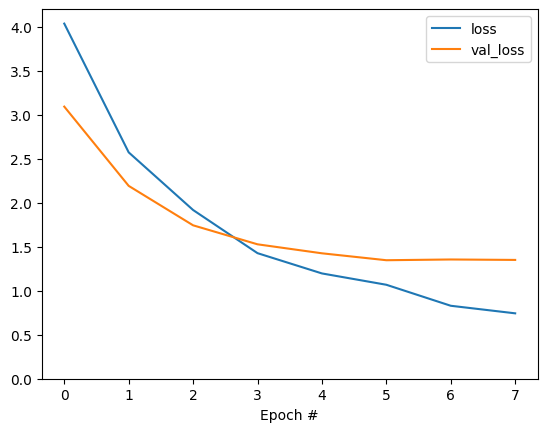

In [44]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.legend()
plt.show()

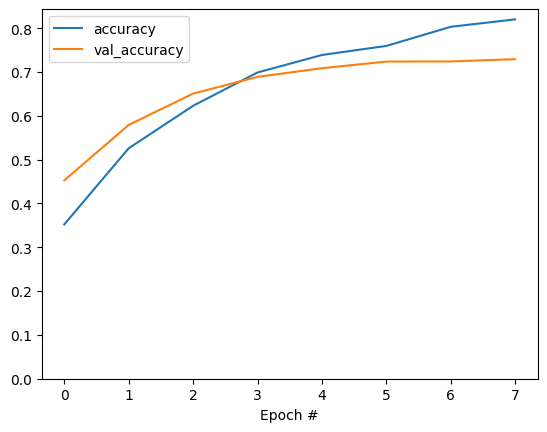

In [45]:
plt.plot(history.history['masked_acc'], label='accuracy')
plt.plot(history.history['val_masked_acc'], label='val_accuracy')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.legend()
plt.show()

In [46]:
# model evaluation after training
model.evaluate(val_ds, steps=20, return_dict=True)

20/20 [==============================] - 1s 28ms/step - loss: 1.3536 - masked_acc: 0.7237 - masked_loss: 1.3536


{'loss': 1.353553056716919,
 'masked_acc': 0.7237287759780884,
 'masked_loss': 1.353553056716919}

In [52]:
#  This function to execute the full text => text translation.
@Translator.add_method
def translate(self, texts, *, max_length=50, temperature=0.0):
  # Process the input texts
  encOutput = self.encoder.convert_input(texts)
  state = encOutput
  batch_size = tf.shape(texts)[0]
  # Setup the loop inputs
  tokens = []
  next_token = tf.fill([batch_size, 1], self.start_token)
  done = tf.zeros([batch_size, 1], dtype=tf.bool)
  
  for _ in range(max_length):
    logits, state = self.decoder(encOutput, next_token,state = state,return_state=True)
    if temperature == 0.0:
      next_token = tf.argmax(logits, axis=-1)
    else:
      logits = logits[:, -1, :]/temperature
      next_token = tf.random.categorical(logits, num_samples=1)

    # If a sequence produces an `end_token`, set it `done`
    done = done | (next_token == self.end_token)
    # Once a sequence is done it only produces 0-padding.
    next_token = tf.where(done, tf.constant(0, dtype=tf.int64), next_token)
    # Collect the generated tokens
    tokens.append(next_token)

    if tf.executing_eagerly() and tf.reduce_all(done):
      break
  # Stack the lists of tokens and attention weights.
  tokens = tf.concat(tokens, axis=-1)   # t*[(batch 1)] -> (batch, t)

  result = self.tokens_to_text(tokens)
  return result

In [53]:
result = model.translate(['¿Todavía está en casa?']) # Are you still home
result[0].numpy().decode()

'is he still at home ? '

In [54]:
inputs = [
    'Hace mucho frio aqui.', # "It's really cold here."
    'Esta es mi vida.', # "This is my life."
    'Su cuarto es un desastre.' # "His room is a mess"
]

In [56]:
for t in inputs:
  print(model.translate([t])[0].numpy().decode())

its very cold here . 
this is my life . 
his rooms a mess . 


In [57]:
long_text = context_raw[-1]
long_text

'Si quieres sonar como un hablante nativo, debes estar dispuesto a practicar diciendo la misma frase una y otra vez de la misma manera en que un músico de banjo practica el mismo fraseo una y otra vez hasta que lo puedan tocar correctamente y en el tiempo esperado.'

In [58]:
result = model.translate([long_text]) # Are you still home
result[0].numpy().decode()

'if you want to sound like a native speaker , you need to know about it . just at least one , but you know , only about the same time that banjo and only sound of the [UNK] [UNK] over and over and over the same [UNK] of the'

### Saving the model

we'll need to wrap the translate method in a tf.function.

In [59]:
class Export(tf.Module):
  def __init__(self, model):
    self.model = model

  @tf.function(input_signature=[tf.TensorSpec(dtype=tf.string, shape=[None])])
  def translate(self, inputs):
    return self.model.translate(inputs)

In [60]:
export = Export(model)
_ = export.translate(tf.constant(inputs))

In [61]:
result = export.translate(tf.constant(inputs))

print(result[0].numpy().decode())
print(result[1].numpy().decode())
print(result[2].numpy().decode())
print()

its very cold here .                                             
this is my life .                                             
his rooms a mess .                                             



In [62]:
tf.saved_model.save(export, 'translator', signatures={'serving_default': export.translate})

In [63]:
reloaded = tf.saved_model.load('translator')
_ = reloaded.translate(tf.constant(inputs)) #warmup

In [64]:
result = reloaded.translate(tf.constant(inputs))

print(result[0].numpy().decode())
print(result[1].numpy().decode())
print(result[2].numpy().decode())
print()

its very cold here .                                             
this is my life .                                             
his rooms a mess .                                             



The short sentences often work well, but if the input is too long the model literally loses focus and stops providing reasonable predictions.